In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, random
from scipy.stats import norm
from scipy.optimize import minimize
import time
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf
from sklearn.covariance import ShrunkCovariance, empirical_covariance, log_likelihood
from pypfopt.efficient_frontier import EfficientFrontier, EfficientCVaR
from pypfopt import risk_models, expected_returns, CLA, plotting
from pypfopt.risk_models import CovarianceShrinkage

In [ ]:
#!pip install PyPortfolioOpt

In [ ]:
SP500_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='SP500 Tech')
ftse_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Vanguard FTSE')
gold_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Gold ETF')
alphabet_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Alphabet')
IAG_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='IAG')
EM_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='MSCI EM')
south_asia_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Southeast Asia')
efae = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='EAFE')

In [ ]:
def construct_df(df, yf = False, start_date='2019-07-25'):
    if yf == False:
        df = df.set_index('Unnamed: 0')
        df = df.rename(columns={df.columns[0]: 'Close'})
    if yf == True:
        df = df.rename(columns={df.columns[0]: 'Close'})
    df['Returns'] = df['Close'].pct_change()
    df['Volatility'] = df['Returns'].rolling(window=252).std() * np.sqrt(252)
    if start_date is not None:
        # Make sure index is datetime
        df.index = pd.to_datetime(df.index)
        df = df.loc[start_date:]
    df['CumProd'] = 100*(1+df['Returns']).cumprod()

    return df.fillna(0)

def getDrawdowns(cumprod):
    peak = cumprod.cummax()
    drawdowns = (cumprod - peak) / peak
    return drawdowns

def getHistoricalVAR(df, level = 5):
    return np.percentile(df['Returns'].dropna(), level)

def getParametricVAR(df, level =5):
    mu = df['Returns'].mean()
    sigma = df['Returns'].std()
    z = norm.ppf(level / 100)
    return mu + z * sigma

def getCVaR(df, level = 5, VAR_historic=True):
    if VAR_historic:
        var = getHistoricalVAR(df, level)
    elif VAR_historic is False:
        var = getParametricVAR(df, level)
    else:
        raise ValueError("VAR_historic must be True (for Historical) or False (for Parametric)")

    return df['Returns'][df['Returns'] <= var].mean()

SP500 = construct_df(SP500_data)
FTSE = construct_df(ftse_data)
Alphabet = construct_df(alphabet_data)
Gold = construct_df(gold_data)
IAG = construct_df(IAG_data)
EM = construct_df(EM_data)
Asia = construct_df(south_asia_data)
EFEA = construct_df(efae)

combined_df = pd.DataFrame({
    'SP500Tech': SP500['Returns'],
    'FTSE': FTSE['Returns'],
    'Alphabet': Alphabet['Returns'],
    'Gold': Gold['Returns'],
    'IAG': IAG['Returns'],
    'EM' : EM['Returns'],
    'AsiaIndex' : Asia['Returns'],
    'EFEA' : EFEA['Returns']

})
covMatrix = combined_df.cov()

def portfolio_return(weights, returns):
    return np.dot(weights, returns.mean()) * 252

def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))

def sharpe_ratio(weights, returns, risk_free_rate=0.0354):
    port_return = portfolio_return(weights, returns)
    port_vol = portfolio_volatility(weights, returns.cov())
    return (port_return - risk_free_rate) / port_vol

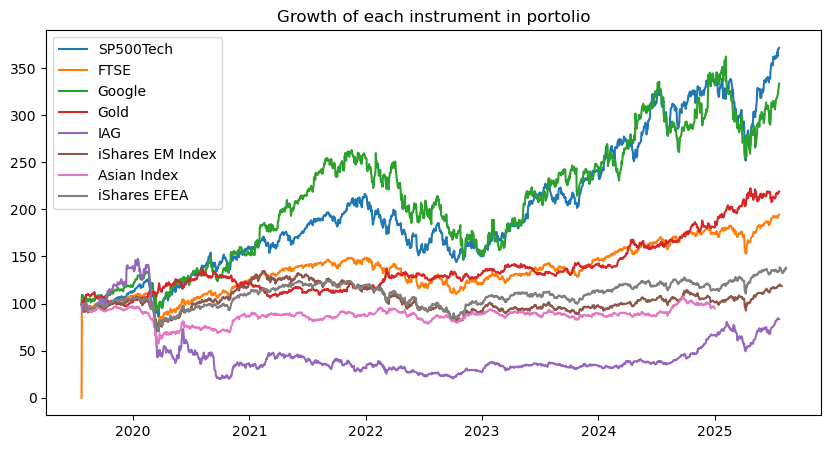

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(SP500.index, SP500['CumProd'], label = 'SP500Tech')
plt.plot(FTSE.index, FTSE['CumProd'], label = 'FTSE')
plt.plot(Alphabet.index, Alphabet['CumProd'], label = 'Google')
plt.plot(Gold.index, Gold['CumProd'], label = 'Gold')
plt.plot(IAG.index, IAG['CumProd'], label = 'IAG')
plt.plot(EM.index, EM['CumProd'], label = 'iShares EM Index')
plt.plot(Asia.index, Asia['CumProd'], label = 'Asian Index')
plt.plot(EFEA.index, EFEA['CumProd'], label = 'iShares EFEA')
plt.legend()
plt.title('Growth of each instrument in portolio')
plt.show()

In [ ]:
SP500['CumProd'].loc['2025-01-01':]

Unnamed: 0
2025-01-01    335.502814
2025-01-02    331.490091
2025-01-03    333.643259
2025-01-06    342.158062
2025-01-07    334.915586
                 ...    
2025-07-15    366.723758
2025-07-16    362.417421
2025-07-17    369.659897
2025-07-18    369.072669
2025-07-21    371.519452
Name: CumProd, Length: 144, dtype: float64

In [ ]:
Asia.tail

<bound method NDFrame.tail of               Close   Returns  Volatility    CumProd
Unnamed: 0                                          
2019-07-25  16.7650 -0.002380    0.176003  99.761976
2019-07-26  16.7100 -0.003281    0.175988  99.434692
2019-07-29  16.3841 -0.019503    0.176524  97.495388
2019-07-30  16.5650  0.011041    0.175933  98.571854
2019-07-31  16.4300 -0.008150    0.174727  97.768521
...             ...       ...         ...        ...
2024-12-25  16.2932  0.000000    0.144604  96.954478
2024-12-26  16.2950  0.000110    0.144601  96.965189
2024-12-27  16.3200  0.001534    0.144492  97.113954
2024-12-30  16.0219 -0.018266    0.145617  95.340077
2024-12-31  15.9460 -0.004737    0.145649  94.888426

[1418 rows x 4 columns]>

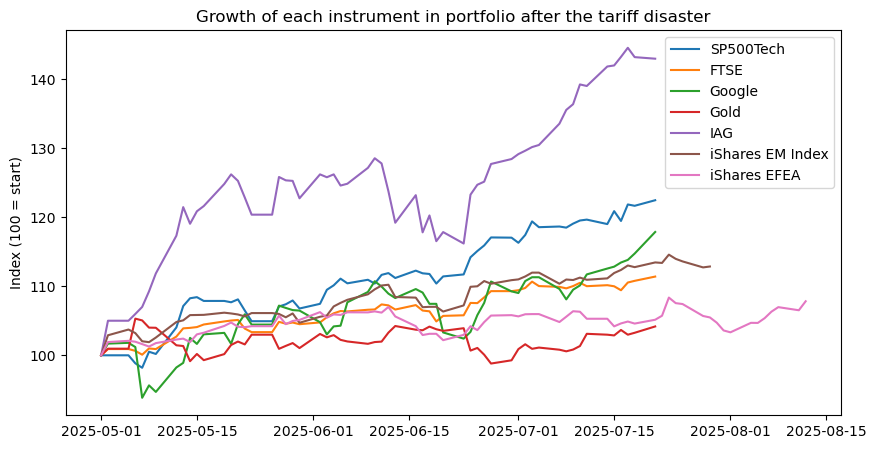

In [ ]:
post_lib_day = '2025-05-01'

plt.figure(figsize=(10, 5))

plt.plot(SP500['CumProd'].loc[post_lib_day:] / SP500['CumProd'].loc[post_lib_day] * 100, label='SP500Tech')
plt.plot(FTSE['CumProd'].loc[post_lib_day:] / FTSE['CumProd'].loc[post_lib_day] * 100, label='FTSE')
plt.plot(Alphabet['CumProd'].loc[post_lib_day:] / Alphabet['CumProd'].loc[post_lib_day] * 100, label='Google')
plt.plot(Gold['CumProd'].loc[post_lib_day:] / Gold['CumProd'].loc[post_lib_day] * 100, label='Gold')
plt.plot(IAG['CumProd'].loc[post_lib_day:] / IAG['CumProd'].loc[post_lib_day] * 100, label='IAG')
plt.plot(EM['CumProd'].loc[post_lib_day:] / EM['CumProd'].loc[post_lib_day] * 100, label='iShares EM Index')
#plt.plot(Asia['CumProd'].loc[post_lib_day:] / Asia['CumProd'].loc[post_lib_day] * 100, label='Asian Index')
plt.plot(EFEA['CumProd'].loc[post_lib_day:] / EFEA['CumProd'].loc[post_lib_day] * 100, label='iShares EFEA')

plt.legend()
plt.title('Growth of each instrument in portfolio after the tariff disaster')
plt.ylabel('Index (100 = start)')
plt.show()


In [ ]:
for col in combined_df.columns:
    print(f"{col} starts on: {combined_df[col].first_valid_index()}")

common_start_date = combined_df.dropna().index.min()
combined_df = combined_df.loc[common_start_date:].copy()

SP500Tech starts on: 2019-07-25 00:00:00
FTSE starts on: 2019-07-25 00:00:00
Alphabet starts on: 2019-07-25 00:00:00
Gold starts on: 2019-07-25 00:00:00
IAG starts on: 2019-07-25 00:00:00
EM starts on: 2019-07-25 00:00:00
AsiaIndex starts on: 2019-07-25 00:00:00


In [ ]:
combined_df

,SP500Tech,FTSE,Alphabet,Gold,IAG,EM,AsiaIndex,EFEA
Unnamed: 0,,,,,,,,
2019-07-25,0.000489,0.000000,-0.003325,-0.002240,-0.021993,-0.007179,-0.002380,-0.010145
2019-07-26,0.002935,0.001752,0.096202,0.008083,-0.015066,0.001368,-0.003281,0.001989
2019-07-29,-0.000244,-0.000375,-0.002714,0.012806,0.001370,-0.002537,-0.019503,0.002137
2019-07-30,-0.004146,-0.005373,-0.011145,0.012644,-0.054264,-0.007239,0.011041,-0.011578
2019-07-31,0.001470,0.001193,-0.007980,-0.005972,0.023144,-0.011037,-0.008150,-0.006628
...,...,...,...,...,...,...,...,...
2025-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006558
2025-08-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008987
2025-08-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006123


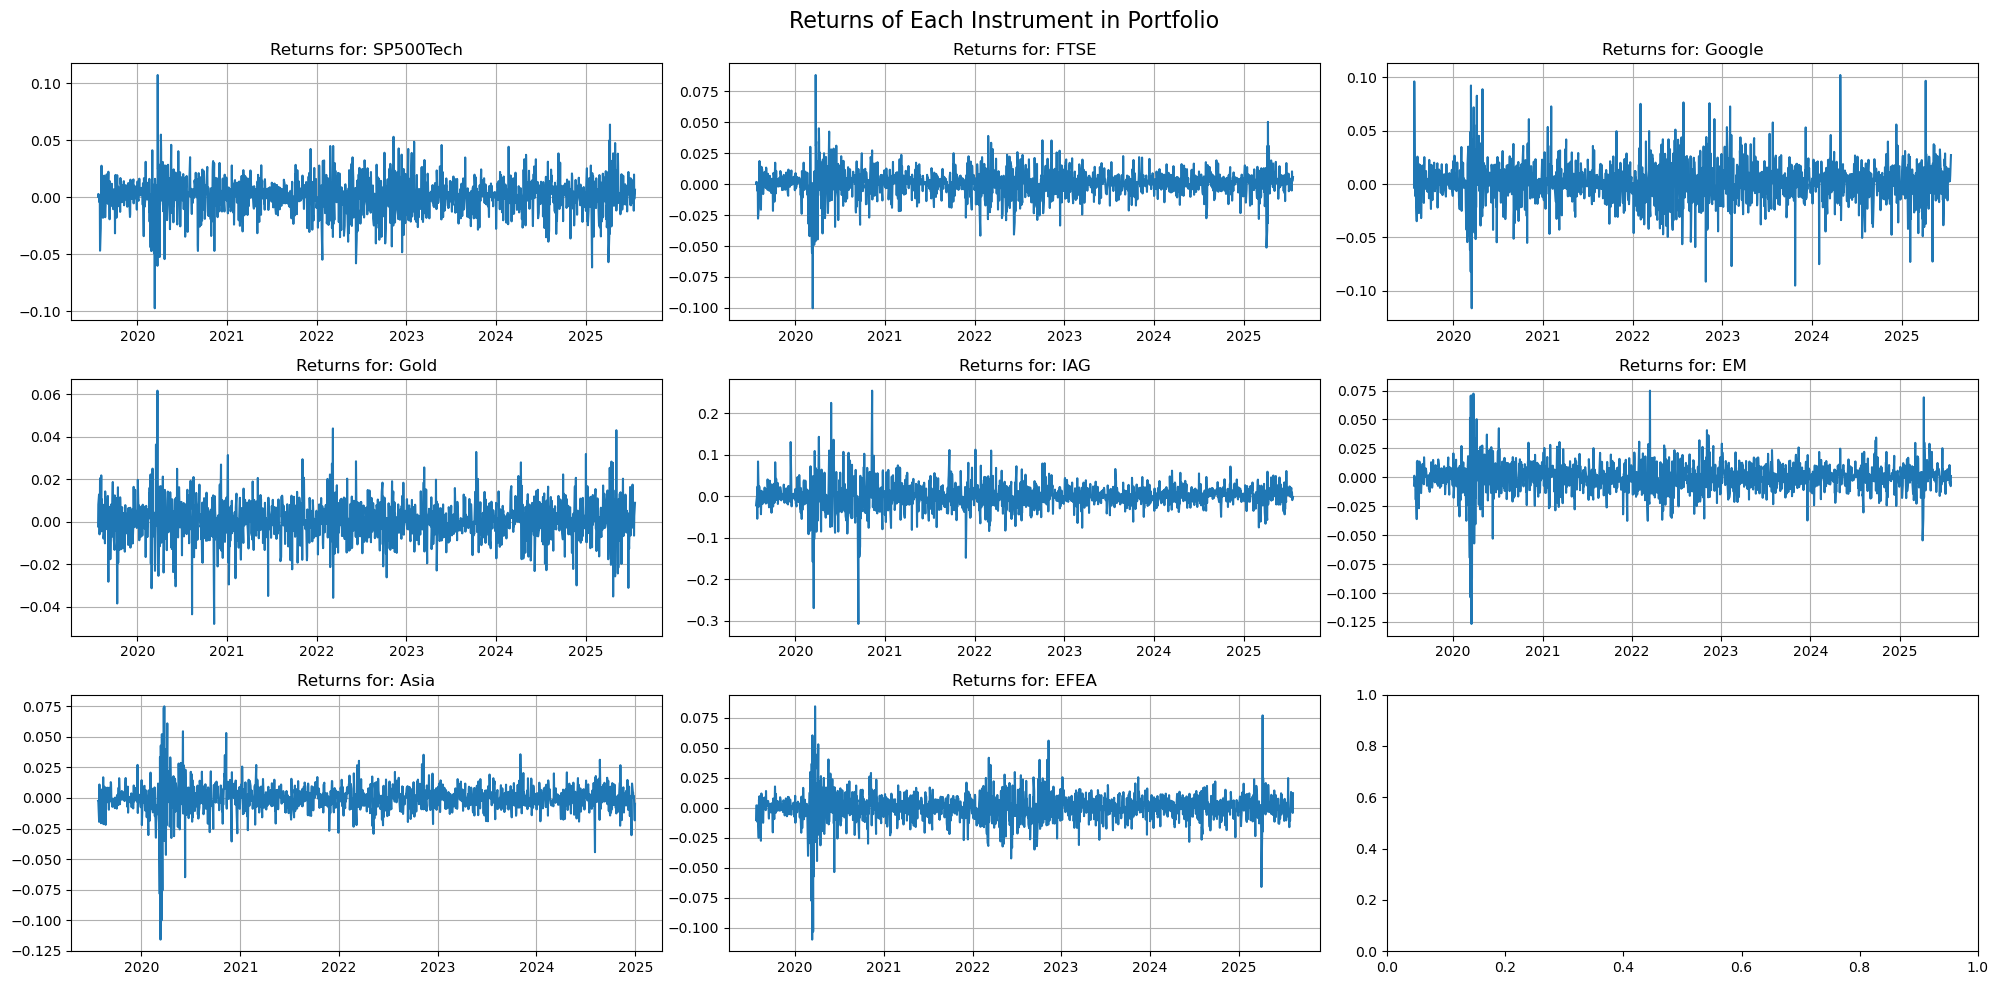

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(20, 10))
axes = ax.flatten()

instruments = [('SP500Tech', SP500), ('FTSE', FTSE), ('Google', Alphabet), ('Gold', Gold), ('IAG', IAG), ('EM', EM), ('Asia', Asia), ('EFEA', EFEA)]
for i, (name, df) in enumerate(instruments):
    axes[i].plot(df.index, df['Returns'], label=name)
    axes[i].set_title(f'Returns for: {name}')
    axes[i].grid(True)


fig.suptitle('Returns of Each Instrument in Portfolio', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
for asset in combined_df.columns:
    ann_vol = combined_df[asset].std() * np.sqrt(252)
    print(f"Annualised Volatility for {asset}: {ann_vol:.4f}")

Annualised Volatility for SP500Tech: 0.2453
Annualised Volatility for FTSE: 0.1754
Annualised Volatility for Alphabet: 0.3151
Annualised Volatility for Gold: 0.1477
Annualised Volatility for IAG: 0.5206
Annualised Volatility for EM: 0.2109
Annualised Volatility for AsiaIndex: 0.1864
Annualised Volatility for EFEA: 0.1918


The annuliased vol shows that IAG is the most volatile (0.52) followed by Alphabet (0.31) then SP500 tech sector (0.24)

In [ ]:
combined_start =combined_df.loc['2019-07-25':'21/07/2025']
combined_start

,SP500Tech,FTSE,Alphabet,Gold,IAG,EM,AsiaIndex,EFEA
Unnamed: 0,,,,,,,,
2019-07-25,0.000489,0.000000,-0.003325,-0.002240,-0.021993,-0.007179,-0.002380,-0.010145
2019-07-26,0.002935,0.001752,0.096202,0.008083,-0.015066,0.001368,-0.003281,0.001989
2019-07-29,-0.000244,-0.000375,-0.002714,0.012806,0.001370,-0.002537,-0.019503,0.002137
2019-07-30,-0.004146,-0.005373,-0.011145,0.012644,-0.054264,-0.007239,0.011041,-0.011578
2019-07-31,0.001470,0.001193,-0.007980,-0.005972,0.023144,-0.011037,-0.008150,-0.006628
...,...,...,...,...,...,...,...,...
2025-07-15,0.015722,-0.001432,0.002423,-0.001035,0.001062,0.006980,NaN,-0.010455
2025-07-16,-0.011743,-0.005214,0.005330,0.007665,0.008749,0.003961,NaN,0.004090
2025-07-17,0.019984,0.010220,0.003334,-0.006579,0.009198,0.005754,NaN,0.002602


In [ ]:
combined_start =combined_df.loc['2019-07-25':'21-07-2025']
annual_returns = {}
for asset in combined_start.columns:
    start_val = combined_start[asset].iloc[0]
    end_val = combined_start[asset].iloc[-1]
    if start_val == 0.00:
        start_val = 0.001
    print('Annual Return', asset, (end_val / start_val) ** (365 / 5) - 1)


Annual Return SP500Tech 4.2232096068383495e+82
Annual Return FTSE 2.6205995579286183e+54
Annual Return Alphabet -4.67191191985934e+66
Annual Return Gold -4.4321738690966565e+43
Annual Return IAG -1.0
Annual Return EM -1.000004280440388
Annual Return AsiaIndex nan
Annual Return EFEA -1.0


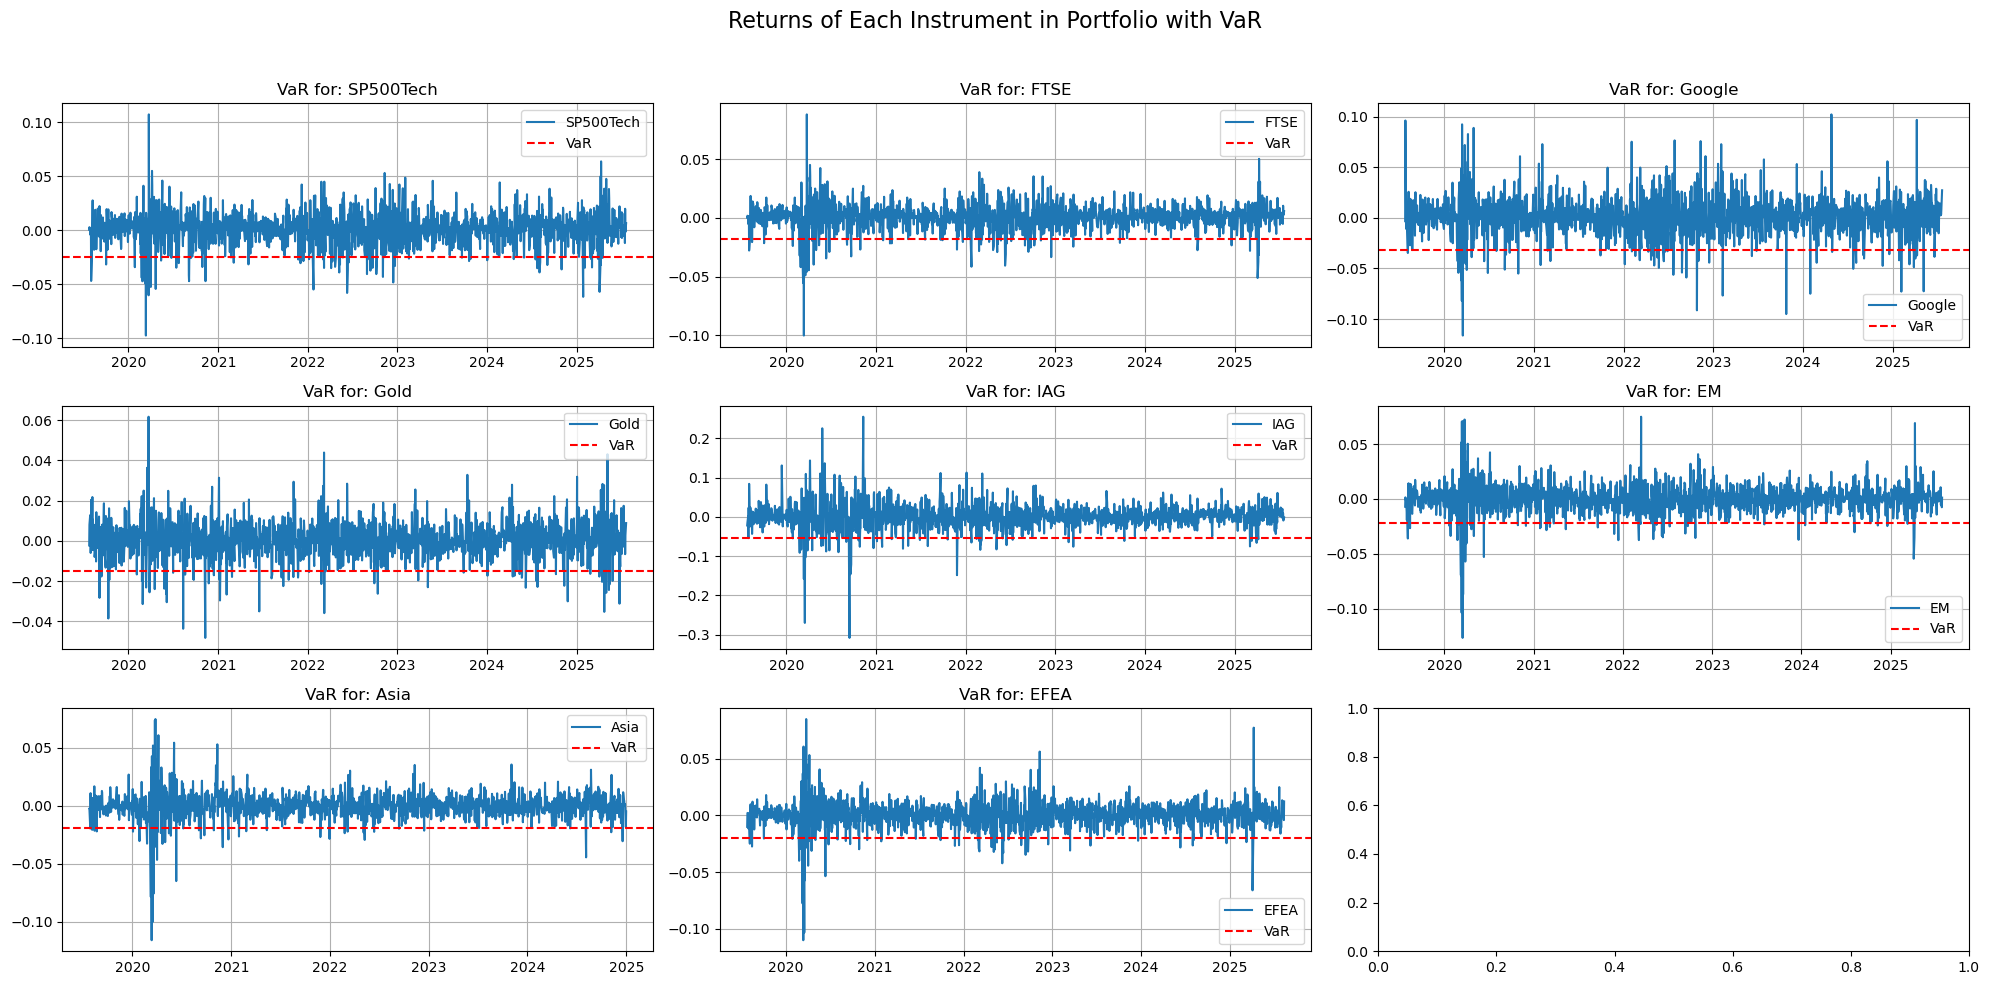

In [ ]:
#again but with their historical VaR, then with CVaR both 95%.
def returns_with_risk_metrics(metric):
    fig, ax = plt.subplots(3, 3, figsize=(20, 10))
    axes = ax.flatten()

    instruments = [('SP500Tech', SP500), ('FTSE', FTSE), ('Google', Alphabet), ('Gold', Gold), ('IAG', IAG), ('EM', EM), ('Asia', Asia), ('EFEA', EFEA)]

    for i, (name, df) in enumerate(instruments):
        axes[i].plot(df.index, df['Returns'], label=name)
        if metric.lower() == 'var':
            risk_line = getParametricVAR(df)
            label = 'VaR'
        elif metric.lower() == 'cvar':
            risk_line = getCVaR(df, level=5, VAR_historic = True)
            label = 'CVaR (95%)'
        else:
            raise ValueError("metric must be 'VaR' or 'CVaR'")
        axes[i].axhline(risk_line, color='red', linestyle='--', label=label)
        axes[i].set_title(f'{metric} for: {name}')
        axes[i].grid(True)
        axes[i].legend()

    fig.suptitle(f'Returns of Each Instrument in Portfolio with {metric}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
returns_with_risk_metrics('VaR')

visually, IAG has the greatest volatility having a vol spread between -0.3 and 0.2, followed by Google and the SP500 tech etf, however it (visually) appears that Google has more upwards (+ve) vol than SP500 tech.
Aside from the large vol cluster in 2020 that is shared between EM and southeast Asia they are not very volatile.

In [ ]:
#get benchamrk data:
benchmark_data = pd.read_excel(r"C:\Users\MarcusConnolly\Downloads\portfolio_data.xlsx", sheet_name='Benchmark')
benchmark = construct_df(benchmark_data)

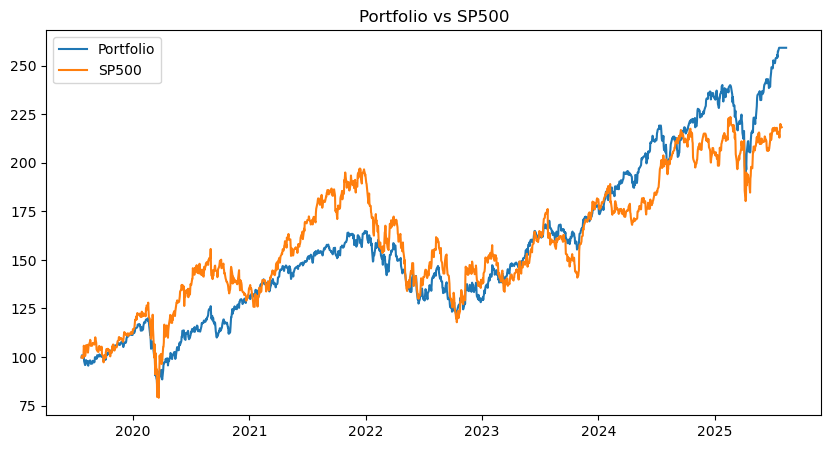

annulised portfolio volatility  0.1779385247381624


In [ ]:
weights = {
    'SP500Tech':0.4044,
    'FTSE': 0.3009,
    'Alphabet' : 0.0956,
    'Gold' : 0.0313,
    'IAG' : 0.0678,
    'EM' :0.0,
    'AsiaIndex': 0.00,
    'EFEA': 0.00
} #as they stand today keeping the EM and SE Asian index at 0 bcos that is for later

combined_df_start_date = combined_df.fillna(0) # fill nans with zeros so the portfolio start date starts at the actula start

weights_array = np.array([weights[col] for col in combined_df_start_date.columns])
portfolio_rets = combined_df_start_date.dot(weights_array)
portfolio_cumprod = 100*(1 + portfolio_rets).cumprod()
portfolio_drawdowns = getDrawdowns(portfolio_cumprod)

plt.figure(figsize=(10,5))
plt.plot(portfolio_cumprod, label='Portfolio')
plt.plot(benchmark.index, benchmark['CumProd'], label='SP500')
plt.title('Portfolio vs SP500')
plt.legend()
plt.show()
print('annulised portfolio volatility ', portfolio_rets.std() * np.sqrt(252))


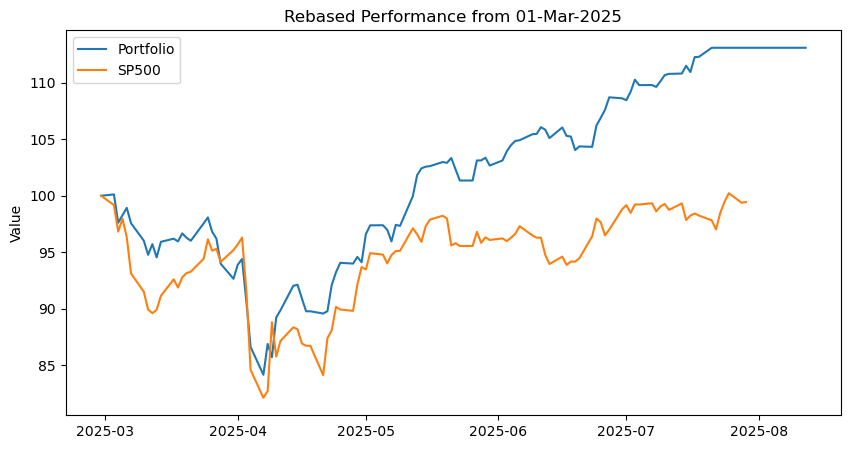

Sharpe Ratio: 0.94
Annual Volatility: 17.79%
Max Drawdown: -31.68%
CAGR: 142.79%
159.45878077092226


In [ ]:
#rebase at 01-March-2025 (as when I started)
start ='2025-02-28'
pos = benchmark['CumProd'].index.get_indexer([start], method='nearest')[0]

portfolio_cumprod_rebased = portfolio_cumprod[start:] / portfolio_cumprod[start] * 100
benchmark_cumprod_rebased = benchmark['CumProd'].iloc[pos:] / benchmark['CumProd'].iloc[pos] * 100

plt.figure(figsize=(10, 5))
plt.plot(portfolio_cumprod_rebased, label='Portfolio')
plt.plot(benchmark_cumprod_rebased, label='SP500')
plt.title('Rebased Performance from 01-Mar-2025')
plt.ylabel('Value')
plt.legend()
plt.show()

sharpe_ratio = portfolio_rets.mean() / portfolio_rets.std() * np.sqrt(252)
volatility = portfolio_rets.std() * np.sqrt(252)
max_drawdown = portfolio_drawdowns.min()
cagr = (portfolio_cumprod.iloc[-1])**(252 / len(portfolio_cumprod)) - 1
tot_return = (portfolio_cumprod.iloc[-1] - portfolio_cumprod.iloc[0])

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annual Volatility: {volatility:.2%}")
print(f"Max Drawdown: {max_drawdown:.2%}")
print(f"CAGR: {cagr:.2%}")
print(tot_return)

# The portfolio current weighting beats the market. Lets see if I can imporve this

Finding EF:

In [ ]:
combined_price_df = pd.DataFrame({
    'SP500Tech': SP500['Close'],
    'FTSE': FTSE['Close'],
    'Alphabet': Alphabet['Close'],
    'Gold': Gold['Close'],
    'IAG': IAG['Close'],
    'EM' : EM['Close'],
    'AsiaIndex' : Asia['Close'],
    'EFEA' : EFEA['Close']

})
mu = expected_returns.mean_historical_return(combined_price_df)
e_cov = CovarianceShrinkage(combined_price_df).ledoit_wolf()
e_cov

C:\Users\MarcusConnolly\anaconda3\Lib\site-packages\pypfopt\expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


,SP500Tech,FTSE,Alphabet,Gold,IAG,EM,AsiaIndex,EFEA
SP500Tech,0.059844,0.036909,0.033361,-0.004877,0.038623,0.023753,0.016212,0.022939
FTSE,0.036909,0.031234,0.021787,-0.003399,0.040562,0.021665,0.016575,0.021852
Alphabet,0.033361,0.021787,0.097486,-0.001488,0.027038,0.035985,0.022869,0.034239
Gold,-0.004877,-0.003399,-0.001488,0.022541,-0.014723,-0.000320,-0.000524,-0.001675
IAG,0.038623,0.040562,0.027038,-0.014723,0.264680,0.036450,0.033741,0.039658
EM,0.023753,0.021665,0.035985,-0.000320,0.036450,0.044642,0.026625,0.033370
AsiaIndex,0.016212,0.016575,0.022869,-0.000524,0.033741,0.026625,0.031989,0.023931
EFEA,0.022939,0.021852,0.034239,-0.001675,0.039658,0.033370,0.023931,0.037380


Min volatility of each asset in portfolio OrderedDict({'SP500Tech': 0.0, 'FTSE': 0.2816346390372678, 'Alphabet': 0.003111155604798088, 'Gold': 0.5171313003707149, 'IAG': 0.0, 'EM': 0.0, 'AsiaIndex': 0.16695744647416963, 'EFEA': 0.03116545851304962})


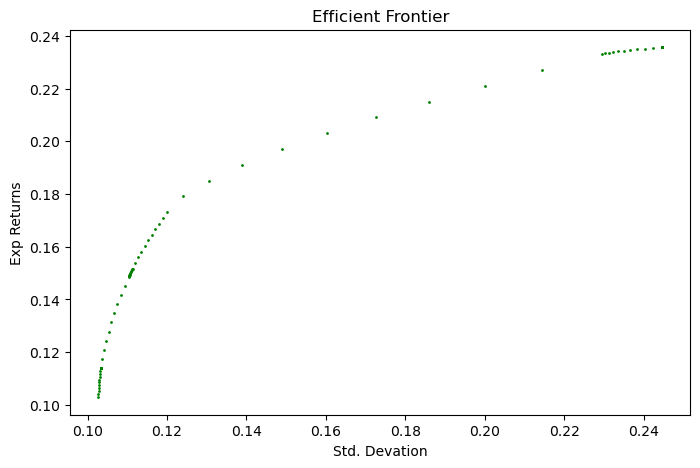

In [ ]:
efficient_portfolio = CLA(mu, e_cov)
print('Min volatility of each asset in portfolio', efficient_portfolio.min_volatility())

(EF_ret, EF_vol, EF_weights) = efficient_portfolio.efficient_frontier()
plt.figure(figsize =(8,5))
plt.scatter(EF_vol, EF_ret, s = 4, c = 'g', marker = '.')
plt.title('Efficient Frontier')
plt.ylabel('Exp Returns')
plt.xlabel('Std. Devation')
plt.show()

In [ ]:
EF_df = pd.DataFrame(np.squeeze(np.array(EF_weights)), columns=mu.index)
EF_df['Returns'] = EF_ret
EF_df['Volatility'] = EF_vol
EF_df.head()

,SP500Tech,FTSE,Alphabet,Gold,IAG,EM,AsiaIndex,EFEA,Returns,Volatility
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235725,0.24463
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235725,0.24463
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235725,0.24463
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235725,0.24463
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235725,0.24463


In [ ]:
ecvar = EfficientCVaR(None, combined_df) #returns df
optimal_weights = ecvar.min_cvar()

assets = ['SP500Tech','FTSE','Alphabet','Gold','IAG','EM','AsiaIndex', 'EFEA']
optimal_weights = {assets[i] : optimal_weights[i] for i in optimal_weights}

print(optimal_weights)

{'SP500Tech': 4.5805e-12, 'FTSE': 0.2879782170813401, 'Alphabet': 2.6581e-12, 'Gold': 0.5567383018777293, 'IAG': 0.0146033179075867, 'EM': 1.7385e-12, 'AsiaIndex': 0.1406801631175772, 'EFEA': 6.7896e-12}


C:\Users\MarcusConnolly\anaconda3\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:149: UserWarning: Removing NaNs from returns
  warnings.warn(


OrderedDict({'SP500Tech': 0.32916085478086243, 'FTSE': 5.267491842670037e-17, 'Alphabet': 0.0890501763221545, 'Gold': 0.5817889688969831, 'IAG': 0.0, 'EM': 0.0, 'AsiaIndex': 0.0, 'EFEA': 0.0})
Expected annual return: 17.6%
Annual volatility: 12.2%
Sharpe Ratio: 1.45


<Axes: xlabel='Volatility', ylabel='Return'>

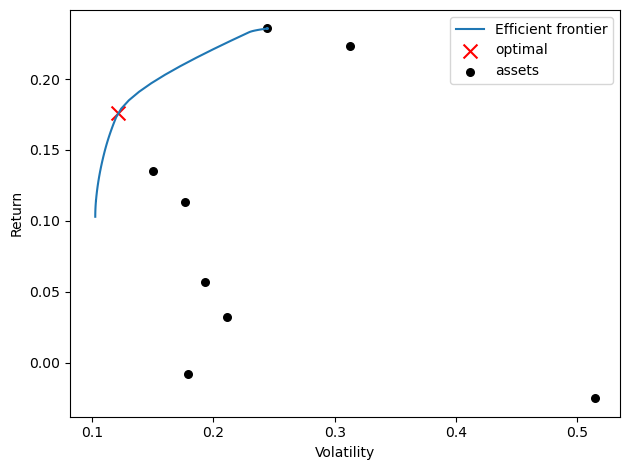

In [ ]:
cla = CLA(mu, e_cov)
print(cla.max_sharpe()) # optimal weights for max sharpe value
cla.portfolio_performance(verbose=True)
plotting.plot_efficient_frontier(cla)

Min volatility weights: OrderedDict({'SP500Tech': 0.0, 'FTSE': 0.2816346390372678, 'Alphabet': 0.003111155604798088, 'Gold': 0.5171313003707149, 'IAG': 0.0, 'EM': 0.0, 'AsiaIndex': 0.16695744647416963, 'EFEA': 0.03116545851304962})
Expected annual return: 10.3%
Annual volatility: 10.3%
Sharpe Ratio: 1.00


<Axes: xlabel='Volatility', ylabel='Return'>

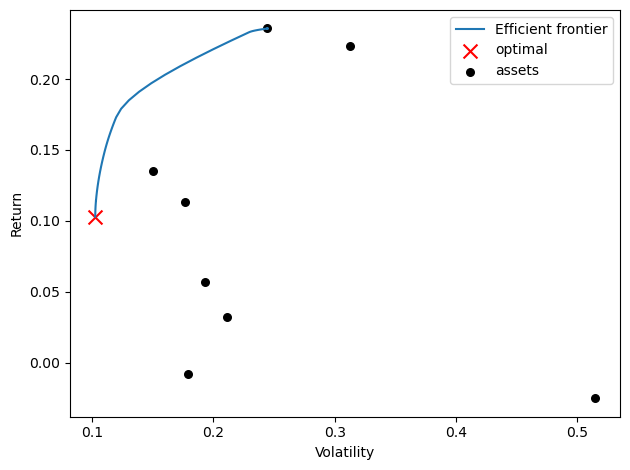

In [ ]:
weights_min_vol = cla.min_volatility()
print("Min volatility weights:", weights_min_vol)
cla.portfolio_performance(verbose=True)
plotting.plot_efficient_frontier(cla)

In [ ]:
#find the highest ret with lowest vol.
max_ret = EF_df["Returns"].max()
max_ret_portfolios = EF_df[EF_df["Returns"] == max_ret]
print('Highest Return for lowest Vol \n', max_ret_portfolios.loc[max_ret_portfolios["Volatility"].idxmin()])


MY_weights = np.array([0.4, 0.3, 0.1, 0.2, 0.0, 0.0, 0.0, 0.3])
MY_ret = np.dot(MY_weights, mu)
MY_vol = np.sqrt(MY_weights @ e_cov @ MY_weights)

print(f"Return: {MY_ret}, Volatility: {MY_vol}")



num_portfolios = 150
results = []

for _ in range(num_portfolios):

    rand_weights = np.random.dirichlet(alpha = np.ones(len(mu)), size = 1)[0]
    rand_weights /= np.sum(weights)

    rand_ret = np.dot(rand_weights, mu)
    rand_vol = np.sqrt(rand_weights @ e_cov @ rand_weights)

    results.append({"Return": rand_ret, "Volatility": rand_vol, "Weights": rand_weights})

MY_df = pd.DataFrame(results)
MY_max_ret = MY_df["Return"].max()
MY_max_ret_portfolios = MY_df[MY_df["Return"] == MY_max_ret]
print('')
print('')
print( MY_max_ret_portfolios.loc[MY_max_ret_portfolios["Volatility"].idxmin()])

Highest Return for lowest Vol 
 SP500Tech     1.000000
FTSE          0.000000
Alphabet      0.000000
Gold          0.000000
IAG           0.000000
EM            0.000000
AsiaIndex     0.000000
EFEA          0.000000
Returns       0.235725
Volatility    0.244630
Name: 10, dtype: float64
Return: 0.19479875509356154, Volatility: 0.2012593379220238


Return                                                  0.17464
Volatility                                             0.193233
Weights       [0.19117627072550408, 0.0852276854418173, 0.43...
Name: 140, dtype: object


In [ ]:
SP500['CumProd'].loc['2025-04-30':]

Unnamed: 0
2025-04-30    289.601174
2025-05-01    303.401028
2025-05-02    303.401028
2025-05-05    303.401028
2025-05-06    299.877661
2025-05-07    297.920235
2025-05-08    304.966968
2025-05-09    303.988255
2025-05-12    315.634940
2025-05-13    325.030585
2025-05-14    328.456080
2025-05-15    328.945437
2025-05-16    327.281625
2025-05-19    327.281625
2025-05-20    326.694397
2025-05-21    327.966724
2025-05-22    323.073159
2025-05-23    318.375336
2025-05-26    318.375336
2025-05-27    324.834842
2025-05-28    325.813555
2025-05-29    327.477367
2025-05-30    323.954000
2025-06-02    326.009298
2025-06-03    332.175190
2025-06-04    334.132616
2025-06-05    337.068755
2025-06-06    335.013457
2025-06-09    336.579398
2025-06-10    334.915586
2025-06-11    338.732567
2025-06-12    339.515537
2025-06-13    337.362368
2025-06-16    340.592121
2025-06-17    339.417666
2025-06-18    339.124052
2025-06-19    334.915586
2025-06-20    338.047468
2025-06-23    338.928309
2025-06-24    

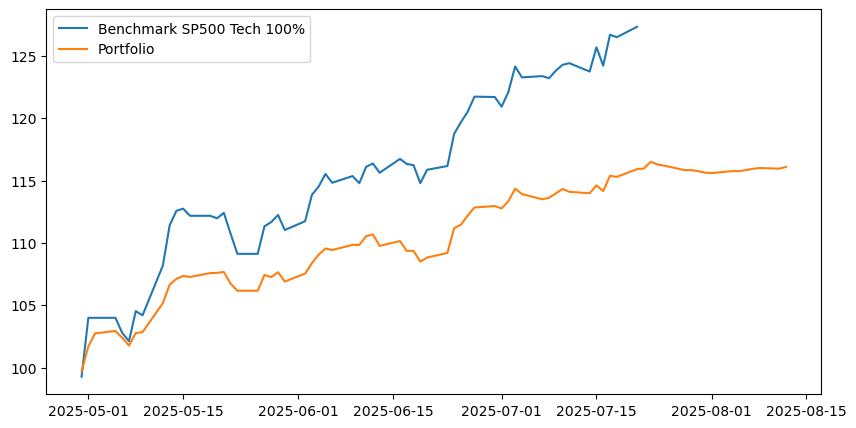

In [ ]:
#create new diversified portfolio based on annual returns, volatility and hope
new_weights = {
    'SP500Tech':0.35,
    'FTSE': 0.23,
    'Alphabet' : 0.0,
    'Gold' : 0.01,
    'IAG' : 0.01,
    'EM' :0.20,
    'AsiaIndex': 0.0,
    'EFEA': 0.10
}

combined_df_start_date = combined_df.loc['2025-04-30':].fillna(0) # fill nans with zeros so the portfolio start date starts at the actula start

weights_array = np.array([new_weights[col] for col in combined_df_start_date.columns])
portfolio_rets = combined_df_start_date.dot(weights_array)
portfolio_cumprod = 100*(1 + portfolio_rets).cumprod()
portfolio_drawdowns = getDrawdowns(portfolio_cumprod)

plt.figure(figsize = (10,5))
plt.plot(100*(1+SP500['Returns'].loc['2025-04-30':]).cumprod(), label = 'Benchmark SP500 Tech 100%')
plt.plot(portfolio_cumprod, label = 'Portfolio')
plt.legend()
plt.show()

In [ ]:
portfolio_cumprod

Unnamed: 0
2019-07-25     99.724061
2019-07-26     99.874105
2019-07-29     99.647014
2019-07-30     99.188170
2019-07-31     98.917928
                 ...    
2025-08-06    206.503719
2025-08-07    206.689298
2025-08-08    206.815861
2025-08-11    206.728897
2025-08-12    206.981593
Freq: B, Length: 1579, dtype: float64